In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
import sys
from ephys import core, events, rasters, rigid_pandas
from neuraltda import topology
import glob
import string
from scipy.io import wavfile
import scipy.signal as signal
from scipy.interpolate import interp1d
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

%pylab inline
reload(topology)
import pandas as pd

/Users/brad/anaconda/envs/neuraltda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


Populating the interactive namespace from numpy and matplotlib


In [ ]:
block_path = '/Volumes/gentner/btheilma/experiments/B1101/Pen01_Lft_AP2500_ML750__Site04_Z2300__B1101_cat_P01_S04_3/'
spikes = core.load_spikes(block_path)
stims = rigid_pandas.load_acute_stims(block_path)
fs = core.load_fs(block_path)
stims['stim_duration'] = stims['stim_end'] - stims['stim_start']
rigid_pandas.timestamp2time(stims, fs, 'stim_duration')
stim_ids = stims['stim_name'].str.replace('_rep\d\d', '')
stim_ids = stim_ids.str.replace('[a-i]001', '')
for motif in 'abcdefgh':
    stim_ids = stim_ids.str.replace('[a-i]%s128'%(motif), motif)
stims['stim_id'] = stim_ids
rigid_pandas.count_events(stims, index='stim_id')
spikes = spikes.join(rigid_pandas.align_events(spikes, stims, columns2copy=['stim_id', 'stim_presentation',
                                               'stim_start', 'stim_duration', 'stim_end']))
spikes['stim_aligned_time'] = (spikes['time_samples'].values.astype('int') -
                               spikes['stim_start'].values)
rigid_pandas.timestamp2time(spikes, fs, 'stim_aligned_time')

In [ ]:
spikes.head()

In [ ]:
def rpGetStimID(rpFrame, trialsRow):
    
    return rpFrame[rpFrame['stim_start'] == trialsRow['time_samples']]['stim_id'].unique()[0]

def rpToTrials(rpFrame):
    
    trialFrame = pd.DataFrame(columns=['time_samples', 'stimulus', 'stimulus_end'])
    trialFrame['time_samples'] = rpFrame['stim_start'].unique()
    trialFrame['stimulus_end'] = rpFrame['stim_end'].unique()
    
    trialFrame['stimulus'] = trialFrame.apply(lambda row: rpGetStimID(rpFrame, row), axis=1)
    
    return trialFrame

In [ ]:
rpToTrials(spikes)

In [3]:
maxt = 100
def plotBarcodeRecursive(resDict):
    
    if 'barcodes' in resDict.keys():
        barcodeDat = resDict['barcodes']
        bettis = barcodeDat.keys()
        for betti in bettis:
            bettiBarcode = barcodeDat[betti]
            nlines = len(bettiBarcode)
            ycoords = [[s,s] for s in range(nlines)]
            xcoords = [[s[0], s[1]+maxt*(s[1] < 0)] for s in bettiBarcode]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBarcodeRecursive(resDict[k])


def plotBettiCurveRecursive(resDict):
    
    if 'bettis' in resDict.keys():
        bettiDat = resDict['bettis']
        bettis = len(bettiDat[0][1])
        for betti in range(bettis):
            ycoords = [s[1][betti] for s in bettiDat]
            xcoords = [s[0] for s in bettiDat]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBettiCurveRecursive(resDict[k])
            
def avgBettiRecursive(bettiDict, bettinum, runningSum, N, maxT, windt):
    if 'bettis' in bettiDict.keys():
        bettiT = np.array([s[0] for s in bettiDict['bettis']])*(windt/1000.)
        maxT = max(bettiT)
        try:
            bettiB = np.array([s[1][bettinum] for s in bettiDict['bettis']])
        except:
            
            bettiB = np.zeros(len(bettiT))
        bfunc = interp1d(bettiT, bettiB, kind='zero', bounds_error=False, fill_value=(bettiB[0], bettiB[-1]))
        t = np.linspace(0, maxT, 1000)
        bvals = bfunc(t)
        return (runningSum + bvals, N+1, maxT)
    else:
        for k in bettiDict.keys():
            runningSum, N, maxT = avgBettiRecursive(bettiDict[k], bettinum, runningSum, N, maxT, windt)
        return (runningSum, N, maxT)
    
def computeAvgBettiCurve(resDict, stim, betti, windt):
    
    stimdata = resDict[stim]
    
    runningSum, N, maxT = avgBettiRecursive(stimdata, betti, np.zeros(1000), 0, 0, windt)
    avgBetti = runningSum / float(N)
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, t, maxT)
    
def plotAvgBettiCurves(avgBetti, t, betti, stim): 
    plt.figure()
    plt.plot(t, avgBetti)
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([0, max(avgBetti)+2])
    plt.xlim([0, max(t)])
    plt.show()
def plotStimAvgMinusTotalAvg(resDict, stim, betti):
    stimdata = resDict[stim]
    t = np.linspace(0, 2, 1000)
    runningSum, N = avgBettiRecursive(stimdata, betti, np.zeros(len(t)), 0, t)
    avgBetti = runningSum / float(N)
    
    totAvg, N = avgBettiRecursive(resDict, betti, np.zeros(len(t)), 0, t)
    totAvg = totAvg/float(N)
    
    
    plt.figure(figsize=(11, 8))
    plt.plot(t, avgBetti-totAvg)
    sns.despine()
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([-5, 5])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Difference')
    plt.savefig('B957P01S01-Stim_{}-Betti_{}.png'.format(stim, betti))
    plt.show()
    
    
def plotEvidenceAverageBettiDifference(resDict, betti):
    
    maxt = 1000
    evRunningSum = np.zeros((7, maxt))
    evN = np.zeros(7)
    
    for stim in resDict.keys():
        ev = computeEvidence(stim)
        stimdata = resDict[stim]
        t = np.linspace(0, 2, maxt)
        runningSum, N = avgBettiRecursive(stimdata, betti, np.zeros(len(t)), 0, t)
        avgBetti = runningSum / float(N)
    
        totAvg, N = avgBettiRecursive(resDict, betti, np.zeros(len(t)), 0, t)
        totAvg = totAvg/float(N)
    
        diff = avgBetti - totAvg
        evRunningSum[ev+3, :] = evRunningSum[ev+3, :] + diff
        evN[ev+3] = evN[ev+3] +1

    for n in range(7):
        evRunningSum[n, :] = evRunningSum[n, :] / float(evN[n])
        plt.figure(figsize=(11, 8))
        plt.plot(t, evRunningSum[n, :])
        sns.despine()
        plt.title('Evidence: %d Betti: %d' %(n-3, betti))
        plt.ylim([-5, 5])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Difference')
        plt.savefig('B957P01S01-Evidence_{}-Betti_{}.png'.format(n-3, betti))
        plt.show()


In [2]:
resFname = '/Volumes/gentner/btheilma/experiments/B1101/Pen01_Lft_AP2500_ML750__Site04_Z2300__B1101_cat_P01_S04_3/20161028T001530Z-25.0-4.0-masterResults.pkl'
with open(resFname, 'r') as f:
    mrDict = pickle.load(f)

In [27]:
computationClass = 'permuted'
results = mrDict[computationClass]
resultsSh = mrDict['permuted-shuffled']
stims = results.keys()


In [28]:
ahstims = [s for s in stims if 'cg' in s]
morphstims = sort(ahstims)

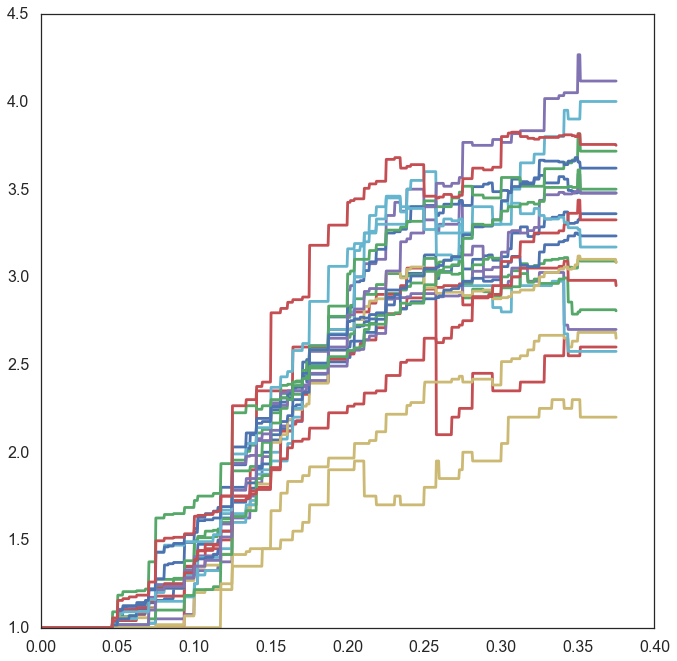

In [31]:
bettisave = np.zeros((1000, len(morphstims)))
betti = 0
windt = 25.0
for ind, stim in enumerate(morphstims):
    (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt)
    bettisave[:, ind] = avgBetti
plt.figure(figsize=(11,11))    
plt.plot(t, bettisave)
    
    

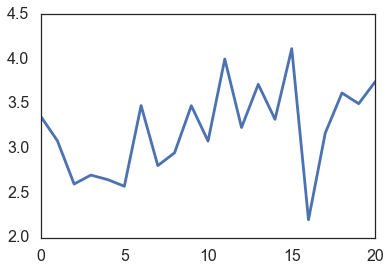

In [32]:
finalvals = bettisave[-1, :]
plt.plot(finalvals)